In [17]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM

In [21]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_ahead{}".format(name,i), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat)))
    

In [3]:
train = pd.read_csv("train_nocat.csv")
test = pd.read_csv("test_nocat.csv")

In [4]:
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

### Seeking outliers

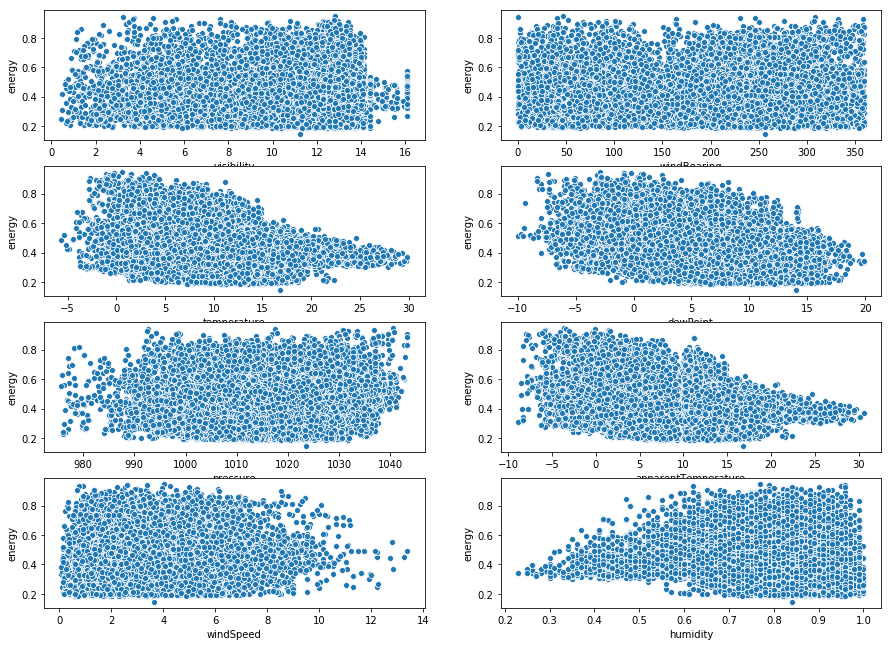

In [12]:
scatter_plot(train)

In [13]:
## deal with the only outliers in  energy data 
train.drop(train[(train["energy"] > 20)].index, inplace = True)
train.reset_index(drop=True, inplace=True)

### Calibration of distribution

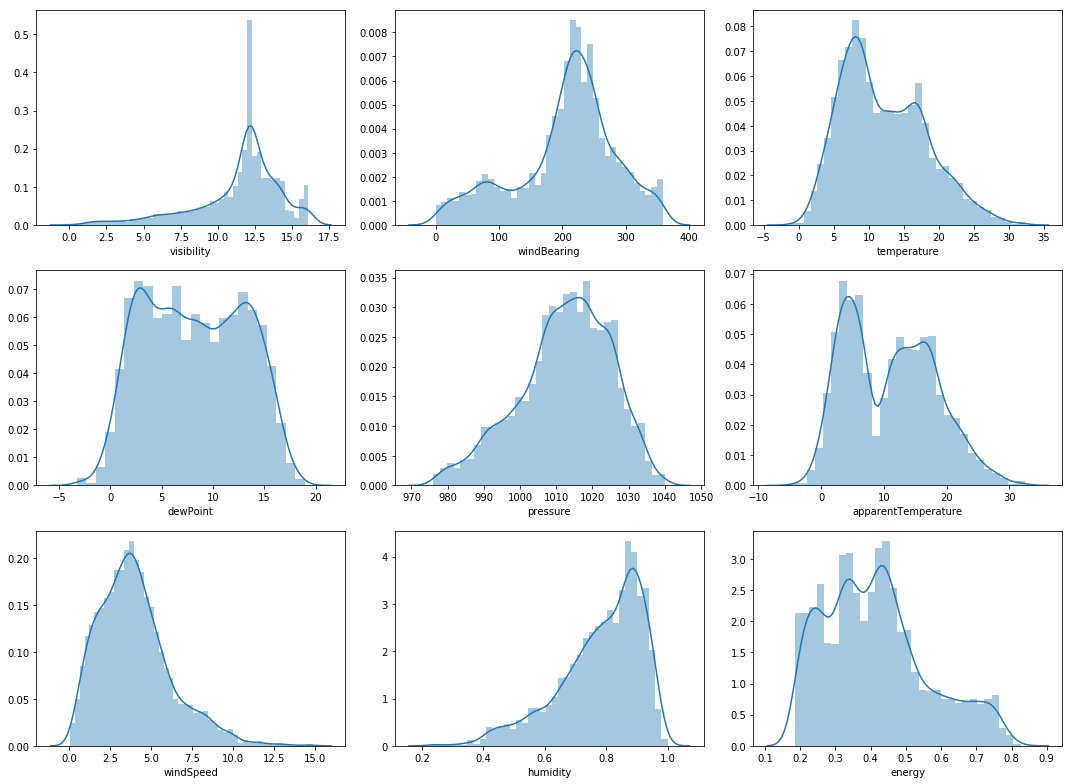

In [13]:
distri_plot(test)


We can observe that 
- left skew: **visibility**, **humidty** 
- right skew:  **windSpeed**, **temperature**
- weird shape: **windBearing**, **dewPoint**, **apparetTemp**

Apply transformation on them for more normal distribution

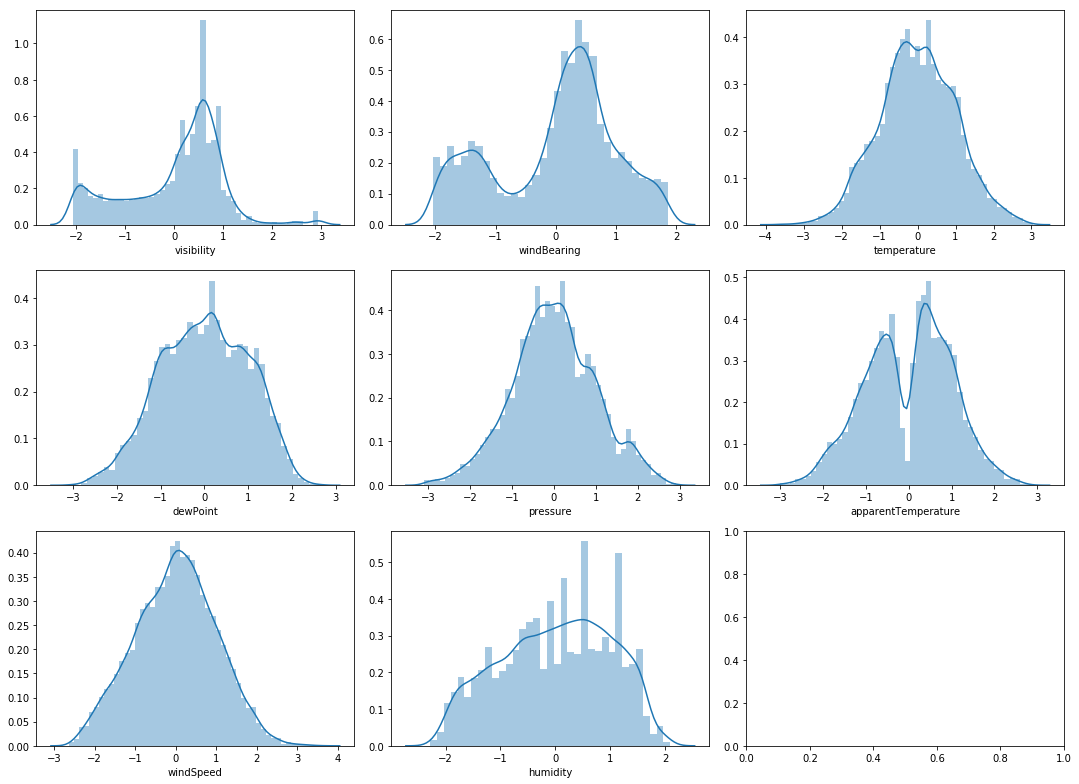

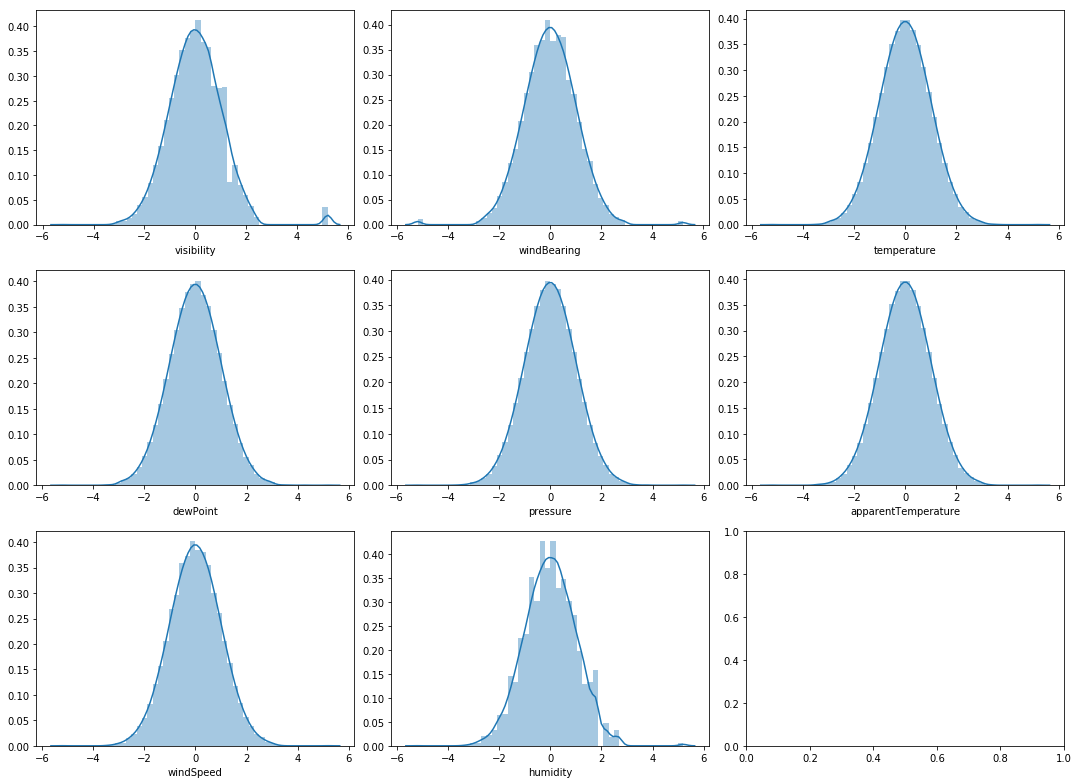

In [294]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
    
def power_trans(df):
    pt_boxc = PowerTransformer(method = "yeo-johnson")
    df_slice = df.iloc[:,:8]
    pt.fit(df_slice)
    df_trans = pd.DataFrame(pt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans
train_trans = power_trans(train)

def quantile_trans(df):
    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
    df_slice = df.iloc[:,:8]
    qt.fit(df_slice)
    df_trans = pd.DataFrame(qt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans

train_trans = power_trans(train)
train_quantile = quantile_trans(train)

##plot distribution
distri_plot(train_trans)
distri_plot(train_quantile)

### Creat lag ahead scenarios

In [5]:
#create 48 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
single_w = train.iloc[:13991,:8]
#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_w.shape, ahead_e.shape, single_w.shape

((13991, 392), (13991, 49), (13991, 8))

### Scaling 

In [6]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ahead_w)
mt = mmscaler.transform(ahead_w)


### Feature Selection

In [7]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(random_state=0).fit(mt, ahead_e)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(mt)
cols ## the selected features column

array([ 98,  99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 134, 136, 139, 143, 146,
       245, 246, 247, 250, 252, 254, 258, 259, 261, 262, 263, 264, 266,
       269, 271, 272, 274, 280, 282, 288, 290, 326, 331, 344, 345, 347,
       350, 351, 354, 355, 356, 358, 359, 361, 364, 365, 369, 371, 377,
       379, 381, 383, 386, 388])



### Random Forest Regression: Manual ML

In [190]:
from sklearn.ensemble import RandomForestRegressor

X = mt_feature
y = ahead_e

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

#for i in range(50):
rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
rfr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [191]:
yhat = rfr.predict(val_X)

### Result evaluation: validation set

**Root Mean Square Error**

In [192]:
mean_squared_error(val_y, yhat)

0.004076983933704106

**Mean Absolute Error**

In [193]:
mean_absolute_error(val_y, yhat)

0.048205666681675856

**R2 score**

In [194]:
r2_score(val_y, yhat)

0.8273037570144528

**Visualization**

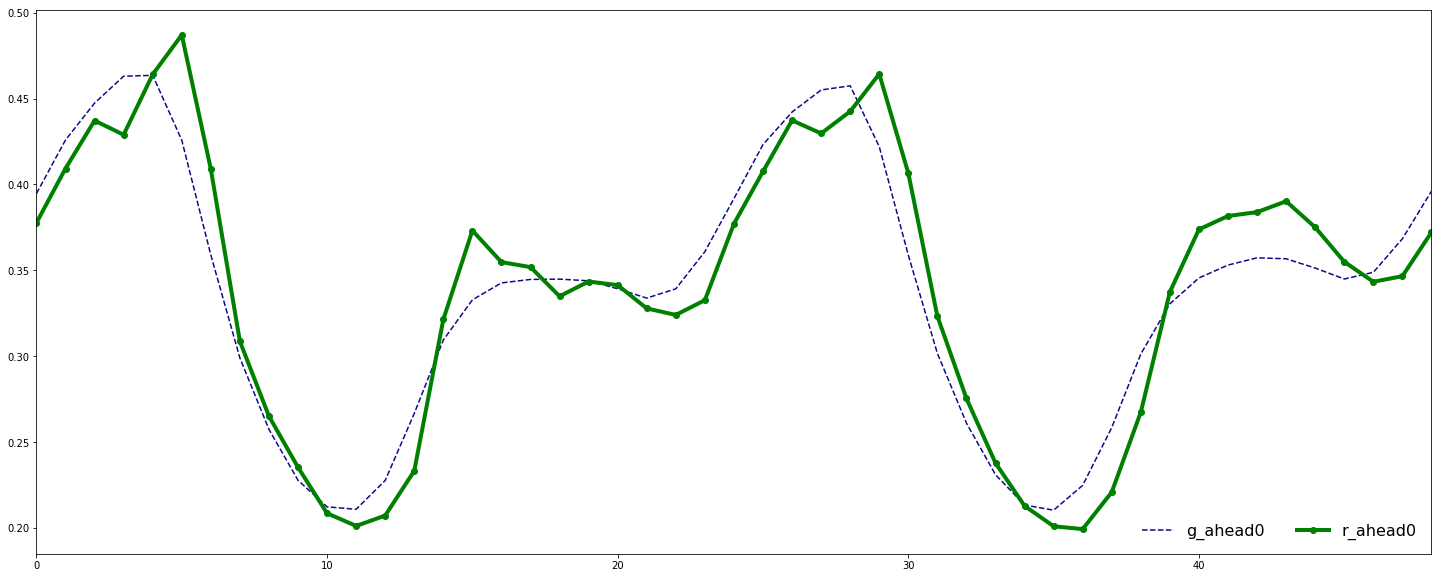

In [195]:
## assignment
real = val_y.to_numpy()
guess = yhat
real = real[:1,:49]
guess = guess[:1,:49]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Result evaluation: test set

**Data preparation for test set**

- prepare recency features
- feature scaling 
- identify feature picked from previous training process

In [25]:
## create 48 hours recency effect matrix
ahead_wt = lag_ahead_series(test.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
#single_wt = train.iloc[:5775,:8]
#create 48 housrs ahead energy consumption matrix
ahead_et = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_wt.shape, ahead_et.shape

((5775, 392), (5775, 49))

In [26]:
## feature scaling
#single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ahead_wt)

In [27]:
## feature pick up
test_x = mtest[:,cols]
test_y = ahead_et

In [199]:
## Prediction with test data
yt_hat = rfr.predict(test_x)

**Mean Square Error**

In [200]:
mean_squared_error(test_y, yt_hat)

0.006686032165989586

**Mean Absolute Error**

In [201]:
mean_absolute_error(test_y, yt_hat)

0.060261760079341156

**R2_score**

In [202]:
r2_score(test_y, yt_hat)

0.6894627184641356

**Visualization**

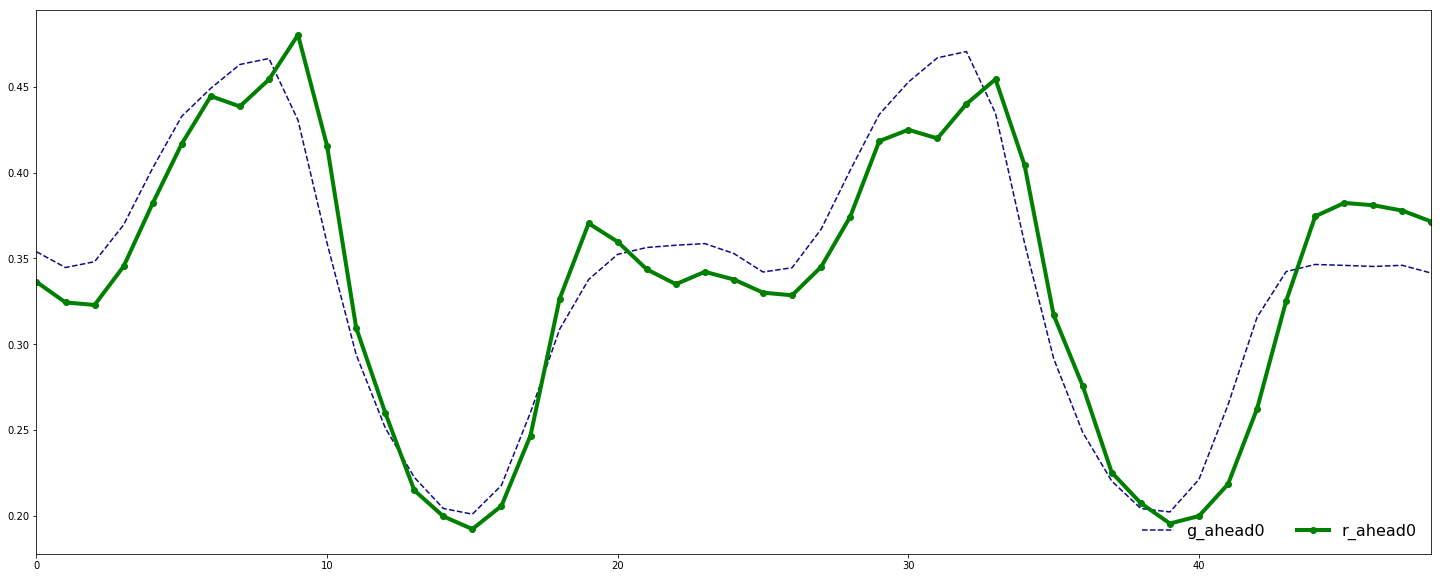

In [204]:
real = test_y.to_numpy()
guess = yt_hat
real = real[100:101,:49]
guess = guess[100:101,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Xgboost: Manual

In [52]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = mt_feature
y = ahead_e
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 8)
#mr = MultiOutputRegressor(xgbr, n_jobs = 4)
#mr.fit(train_X, train_y)
rc = RegressorChain(xgbr, cv = 5, random_state = 123)
rc.fit(train_X, train_y)

[22:59:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:00:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:18:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:43:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:10:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:36:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RegressorChain(base_estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           importance_type='gain',
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=10, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, njobs=8, nthread=None,
                                           objective='reg:linear',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=

### Result evaluation: test set

In [53]:
yhat = mr.predict(val_X)

In [54]:
get_eval(val_y, yhat)

MSE: 0.0009407807361554104
MAE: 0.015613013013415871
r2_score: 0.9601076576134726


**Visualization**

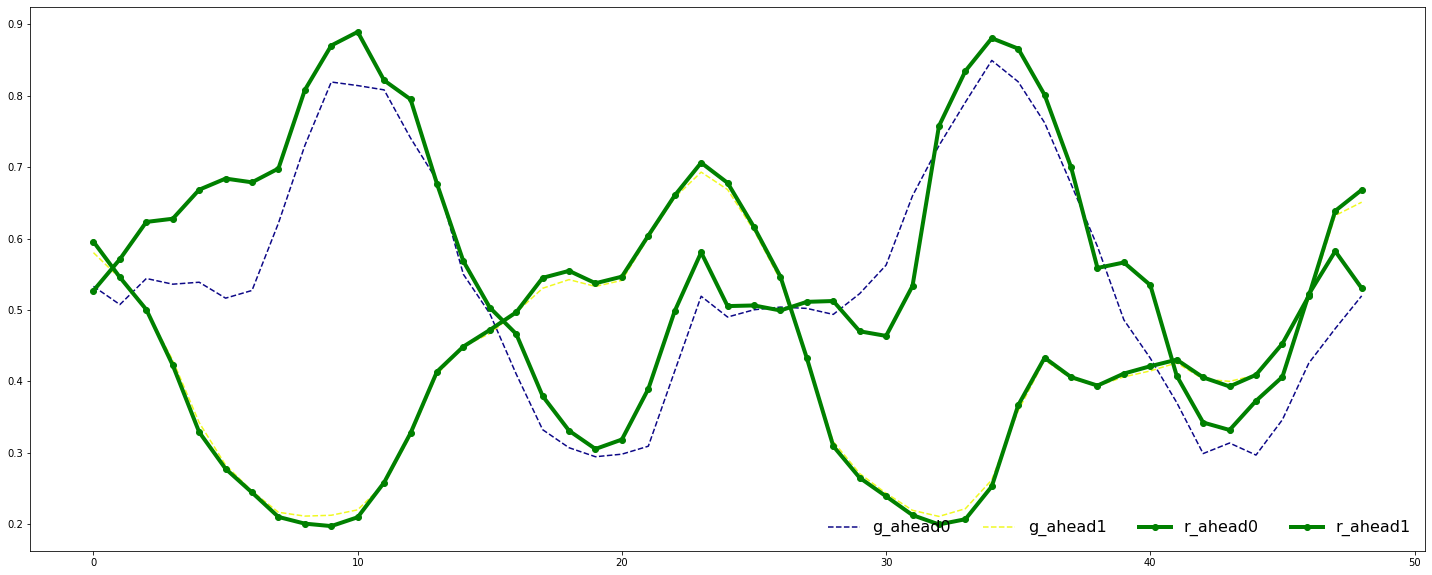

In [56]:
real = val_y.to_numpy()
guess = yhat
real = real[99:101,:49]
guess = guess[99:101,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Result evaluation: test set

In [57]:
yhat = rc.predict(test_x)

In [58]:
get_eval(test_y, yhat)

MSE: 0.006146311995818374
MAE: 0.055119984116775565
r2_score: 0.7145231955924491


**Visualization**


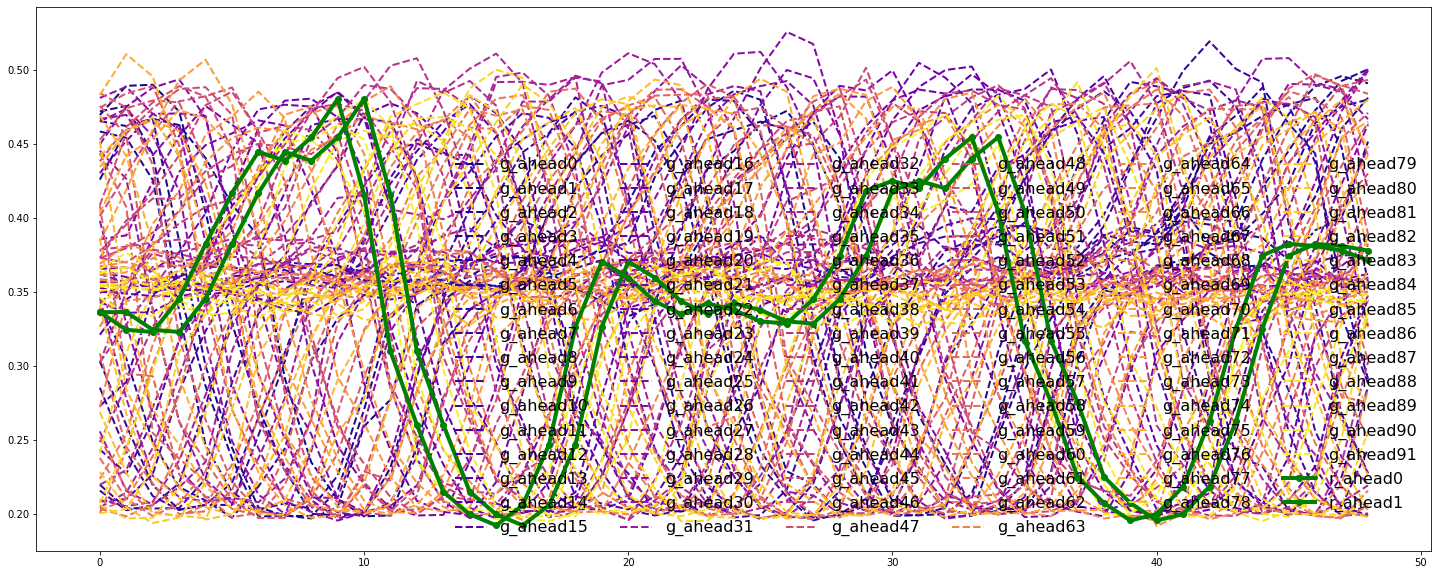

In [61]:
real = test_y.to_numpy()
guess = yhat
real = real[99:101,:49]
guess = guess[9:101,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             25800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49)             2499      
Total params: 28,299
Trainable params: 28,299
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 0.1620
Epoch 2/50
 - 2s - loss: 0.1154
Epoch 3/50
 - 2s - loss: 0.1050
Epoch 4/50
 - 2s - loss: 0.0978
Epoch 5/50
 - 2s - loss: 0.0928
Epoch 6/50
 - 2s - loss: 0.0894
Epoch 7/50
 - 2s - loss: 0.0876
Epoch 8/50
 - 2s - loss: 0.0863
Epoch 9/50
 - 2s - loss: 0.0852
Epoch 10/50
 - 2s - loss: 0.0843
Epoch 11/50
 - 2s - loss: 0.0837
Epoch 12/50
 - 2s - loss: 0.0831
Epoch 13/50
 - 2s - loss: 0.0826
Epoch 14/50
 - 2s - loss: 0.0821
Epoch 15/50
 - 2s - loss: 0.0817
Epoch 16/50
 - 2s - loss: 0.0813
Epoch 17/50
 - 

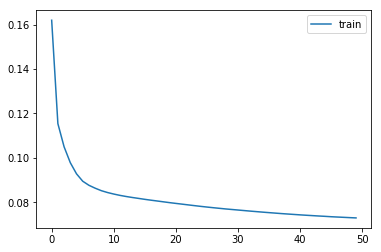

In [37]:
train_X, val_X, train_y, val_y = train_test_split(X_new, y_train_minmax, train_size = 0.9, test_size = 0.1)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))

from keras.layers import TimeDistributed
# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(49)))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

**performace**


In [46]:
import math
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.098


In [43]:
#data preprocess
real = test_y
guess = yhat

real = real[:1,:]
guess = guess[:1,:]

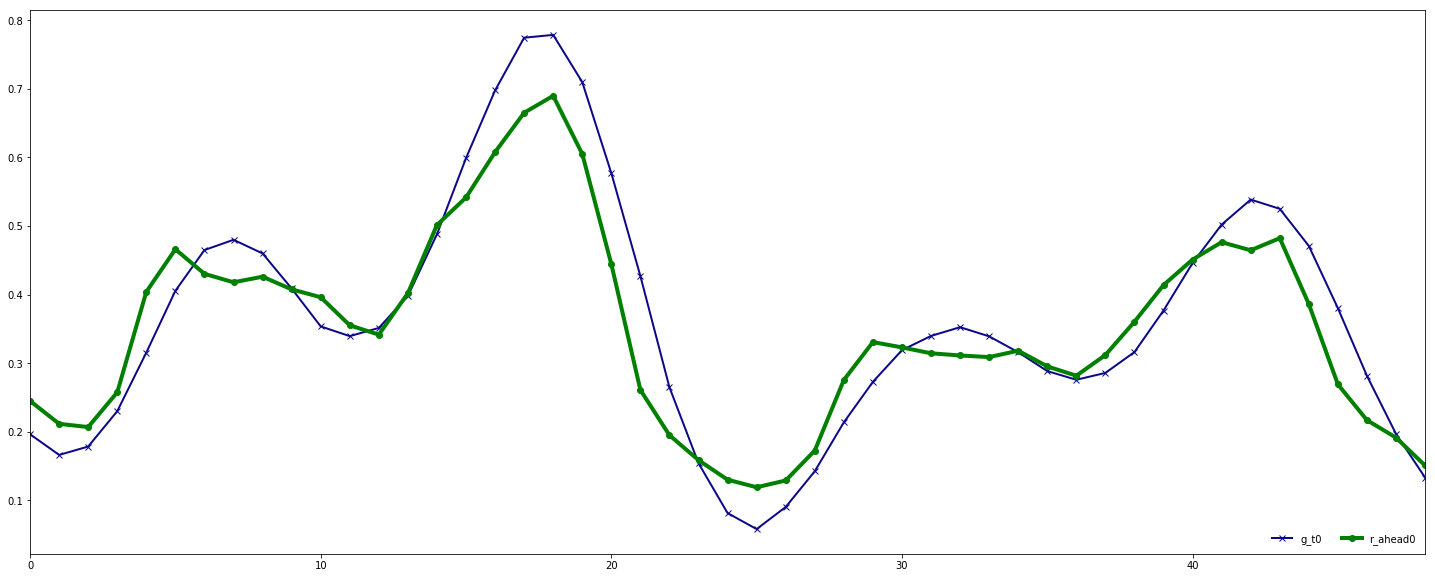

In [45]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

ax = plt.gca()

    
#plot 
gpdf.plot(figsize=(25,10),colormap='plasma',style='-x',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color='Green',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()